In [ ]:
import math
import random
import requests
import time

import numpy as np
import torch
import torchvision

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import torch.nn.functional as F

from io import BytesIO
from PIL import Image

# Lakota AI Code Camp Lesson 16: Object Detection Loss and Metrics

We've covered loss functions and metrics and why they're important.
Now, we're going to talk more about loss functions that are specific to object detection.
We're mainly going to focus on the loss functions used for YOLO, DINO, and SSD object detection models.

First, we're going to talk about metrics that are used throughout object detection models and how to implement some of them.


## Object Detection Metrics

The primary object detection metric will be several variations of what is called average precision.
This metric is heavily dependent on other metrics.
In particular, the IoU metric.
So, we'll talk about the IoU metric.

IoU stands for Intersection over Union.
It's a function that takes in two bounding boxes, the predicted bounding box and the bounding box in the dataset.
We find the intersection of these two bounding boxes and then we divide that by the union.

In [ ]:
def IoU(actual, predict):
    # We assume that actual and predict are in bottom left-top right bounding box format.

    # Ensure that our actual and predict boxes are between 0 and 1.
    actual /= sum(actual)
    predict /= sum(predict)

    ax1, ay1, ax2, ay2 = actual
    px1, py1, px2, py2 = predict

    # Calculate the bottom left of the intersection
    ix1 = max(ax1, px1)
    iy1 = max(ay1, py1)

    # Calculate the top right of the intersection
    ix2 = min(ax2, px2)
    iy2 = min(ay2, py2)

    t = iy2 <= iy1 or ix2 <= ix1

    if t:
        return 0

    # Area is the height times the width.
    intersection = (iy2 - iy1) * (ix2 - ix1)


    # Calulating the interesection over the union using the inclusion exclusion formula
    union = (ax2 - ax1) * (ay2 - ay1) + (px2 - px1) * (py2 - py1) - intersection

    return intersection / union

In [ ]:
def generate_bbox():

    x1 = np.random.uniform()
    y1 = np.random.uniform()
    x2 = np.random.uniform(low=x1)
    y2 = np.random.uniform(low=y1)

    return np.array([x1, y1, x2, y2])

In [ ]:
actual = generate_bbox()
predict = generate_bbox()

0
[0.12540981 0.25141144 0.29634726 0.32683149] [0.30883897 0.13095918 0.32274537 0.23745647]


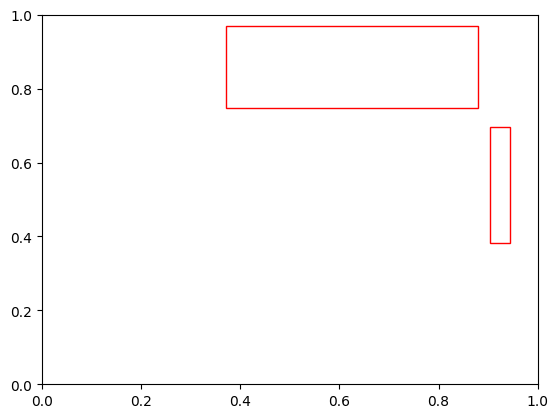

In [ ]:
fig, ax = plt.subplots()

rect = []
for b in (actual, predict):
    x1, y1, x2, y2 = b
    w = abs(x2-x1)
    h = abs(y2-y1)
    x = x1
    y = y1
    rect.append(patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none'))

# Add the patch to the Axes
for r in rect:
    ax.add_patch(r)

print(IoU(actual, predict))
print(actual, predict)

plt.show()

Recall that during the lecture about the AUROC metric, that we talked about true positives, false positives, true negatives, and false negatives.
There are two more metrics associated with those concepts:
*   **precision**
*   **recall**

Precision, mathematically is:
$$
\frac{TP}{TP + FP},
$$
So, the number of correct predictions divided by the number of total predictions.
Recall, mathematically is:
$$
\frac{TP}{TP + FN}
$$
or the number of correct predictions divided by the number of total labels.

Again, our model spits out a probability vector, not a prediction.
We need a threshold value to give a prediction.
That threshold value does not come from the probability vector only, but also comes from the bounding box.
So, we calculate the IoU of the ground truth bounding box and the predicted bounding box.
There are two thresholds:
1.  the threshold on the IoU metric;
1.  the threshold on the probability vector.

We count something as a prediction if the IoU metric ground truth and the predicted bounding box are greater than, say 0.50.
Then we calculate the precision and recall curves.

Finally, average precision is the AUROC for the precision and recall curves calculated.

Finally, the mean average precision is defined as:
$$
\frac{1}{k} \sum_{i = 1}^{k} \textrm{AP}_{i}
$$
where there are $k$ classes, $\textrm{AP}_{i}$ is the average precision of the $i$th class.